# Example: Product sales under different promotions (synthetic data)

## Import relevant code

In [1]:
import sys
sys.path.append("../..")
sys.path.append("../../..")

import pandas as pd
import numpy as np
from time import time
from algorithms.snn import SNN
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score
import pandas as pd
from baselines import naive_ATE, ipw_estimator

## Data inspection

In [69]:

df_all = pd.read_csv("data/product_sales/product_sales.csv")
df_all.time = pd.to_datetime(df_all.time)
df_all.index = pd.to_datetime(df_all.time)
df_all.sample(5)


,product_id,time,category,gender,is_discounted,is_limited_edition,is_fair_trade,is_returnable,has_size_option,is_machine_washable,is_premium,is_ironable,is_imported,white_label,sales,promo
time,,,,,,,,,,,,,,,,
2020-01-12,69,2020-01-12,Underwear,Women's Wear,0,0,0,0,1,1,1,1,0,0,36310.408110,Promo 2
2019-07-28,80,2019-07-28,Activewear,Children's Wear,1,1,1,1,0,0,0,0,1,1,35018.353625,Promo 2
2018-10-14,51,2018-10-14,Underwear,Women's Wear,1,1,1,1,1,1,1,1,1,1,33635.355662,Promo 2
2017-04-30,14,2017-04-30,Activewear,Men's Wear,0,1,1,0,0,0,0,0,0,0,20104.579182,Promo 1
2019-05-19,98,2019-05-19,Underwear,Unisex,1,0,0,1,1,1,1,1,1,1,46095.278414,control


## Let's focus on one product 

In [70]:
target_unit = 49


df_all.loc[(df_all.product_id == target_unit) ].iloc[-1,:]


product_id                              49
time                   2020-12-20 00:00:00
category                         Underwear
gender                     Children's Wear
is_discounted                            0
is_limited_edition                       0
is_fair_trade                            0
is_returnable                            0
has_size_option                          1
is_machine_washable                      1
is_premium                               1
is_ironable                              1
is_imported                              0
white_label                              0
sales                         32431.718216
promo                              Promo 2
Name: 2020-12-20 00:00:00, dtype: object

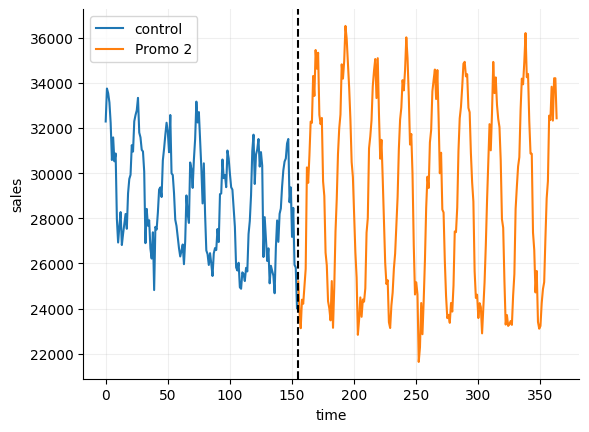

In [71]:
pre_treatment = df_all.loc[(df_all.product_id == target_unit) & (df_all.promo == "control"), ['sales', 'time']].values
post_treatment = df_all.loc[(df_all.product_id == target_unit) & (df_all.promo == "Promo 2"),  ['sales', 'time']].values
T0 = pre_treatment.shape[0]
fig, ax = plt.subplots()
ax.plot( pre_treatment[:,0], label = "control")
ax.plot( np.arange(T0, T0 + len(post_treatment)), post_treatment[:,0], label = "Promo 2")
ax.set_xlabel("time")
ax.set_ylabel("sales")
ax.axvline(T0, linestyle = "dashed", color = "black")
# Set up grid lines
ax.grid(True, which='both', linestyle='-', alpha=0.2)

# Remove upper and left boundaries
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.legend()
plt.show()

## Goal.

### **1. What would have happened to the sales of product 49 under control?**

### **2. What would have happened to the sales of product 49 under Promo 1?**

### **3. What will happen to the sales of product 49 under any of the three interventions?**

### **4. Can we estimate the average treatment effect (ATE) for each intervention despite access to observatoinal data only?**


## Our WhatIf can answer such questions!

### Split data into training and testing 

In [72]:
# leave the last 16 weeks for testing forecasting!
test_t =  16
test_time_stamp = df_all.index.max() - pd.Timedelta(f"{test_t}w")
df = df_all.loc[df_all.index <= test_time_stamp].copy()
df.sample(10)

,product_id,time,category,gender,is_discounted,is_limited_edition,is_fair_trade,is_returnable,has_size_option,is_machine_washable,is_premium,is_ironable,is_imported,white_label,sales,promo
time,,,,,,,,,,,,,,,,
2020-05-31,16,2020-05-31,Outerwear,Unisex,1,0,0,1,0,0,0,0,1,1,33420.396567,Promo 2
2016-02-14,29,2016-02-14,Outerwear,Women's Wear,1,0,0,1,0,0,0,0,0,0,30262.088778,control
2019-02-17,88,2019-02-17,Underwear,Unisex,0,1,1,0,1,1,1,1,0,0,40621.241921,Promo 2
2020-03-08,2,2020-03-08,Underwear,Unisex,1,0,0,1,1,1,1,1,1,1,34721.653558,Promo 2
2016-10-09,79,2016-10-09,Activewear,Children's Wear,1,1,1,1,0,0,0,0,1,1,29063.240629,control
2017-10-15,48,2017-10-15,Underwear,Children's Wear,1,1,1,1,1,1,1,1,1,1,47629.768335,Promo 1
2017-12-31,48,2017-12-31,Underwear,Children's Wear,1,1,1,1,1,1,1,1,1,1,41650.986934,Promo 1
2020-05-24,90,2020-05-24,Underwear,Women's Wear,0,1,1,0,1,1,1,1,0,0,31606.731262,Promo 1
2017-05-07,18,2017-05-07,Activewear,Unisex,0,1,1,0,0,0,0,0,0,0,32950.647679,Promo 2


### Import and fit WhatIf model (using SNN algorithm) 

In [73]:
from whatIf.algorithms.snn import SNN
model = SNN(verbose=False, L = 4, k_factors=8, num_lags_forecasting= 60)

In [74]:

model.fit(
          # first input is the dataframe
          df= df, 
          # for unit_column choose the column name in df with the unique identifier for units (product_id in this data)
          unit_column="product_id",
          # for time_column choose the column name in df with the timestamps (time in this data)
          time_column="time",
          # for metrics choose the column name in df with the metric measurements (sales in this data)
          metrics = ["sales"],
          # for actions choose the column(s) name in df indicating the intervention (promo in this data)
          actions = ["promo"]
)


And just like that, we can answer the four questions above using 
1. `query` function for retrospective questions
2. `forecast` for forecasting questions. 

Let's start with the first question. 

### 1. What would have happened to the sales of product 49 under control?


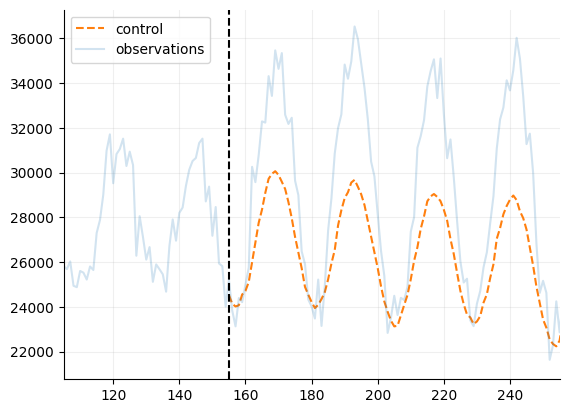

In [75]:
T = model.T
df_query = model.query(
            # which unit(s) to query?
            units= [target_unit], 
            # time frame to query?
            time = ["2016-12-20", test_time_stamp],
            # metric and action to query
            metric= 'sales', action= 'control', 
            # time range at which the selected action should be assigned (for other timesteps,  the observed action will be assigned)
            action_time_range=["2016-12-20", test_time_stamp])

fig, ax = plt.subplots()
ax.plot(np.arange(T0, T),df_query.T.values,'--', color = "tab:orange",  label  = "control")
ax.plot(df.loc[(df.product_id == target_unit) ,  ['sales']].values, alpha = 0.2, label = "observations")
ax.axvline(T0, linestyle = "dashed", color = "black")
plt.legend()
ax.grid(True, which='both', linestyle='-', alpha=0.2)
ax.set_xlim(T0-50,T0+100)


# Remove upper and left boundaries
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.legend()
plt.show()

The query result suggests that the Promo 2coupones have increased sales compared to control. But was this the best action for this unit? let's check the other action `Promo 1`. 

### 2. What would have happened to the sales of product 49 under Promo 1?


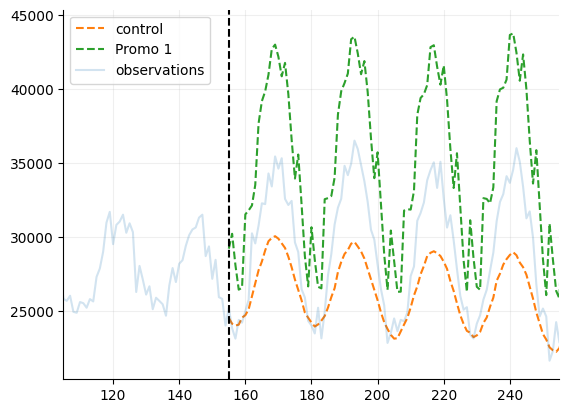

In [76]:
df_query = model.query(units= [target_unit], 
            time = ["2016-12-20", test_time_stamp],
            metric= 'sales', action= 'control', 
            action_time_range=["2016-12-15", " 2020-12-19"])

fig, ax = plt.subplots()
ax.plot(np.arange(T0, T),df_query.T.values,'--', color = "tab:orange",  label  = "control")

df_query = model.query(units= [target_unit], 
            time = ["2016-12-20", test_time_stamp],
            metric= 'sales', action= 'Promo 1', 
            action_time_range=["2016-12-15", " 2020-12-19"])


ax.plot(np.arange(T0, T), df_query.T.values, '--', color = "tab:green", label  = "Promo 1")


ax.plot(df.loc[(df.product_id == target_unit) ,  ['sales']].values, alpha = 0.2, label = "observations")
ax.axvline(T0, linestyle = "dashed", color = "black")
ax.set_xlim(T0-50,T0+100)

ax.grid(True, which='both', linestyle='-', alpha=0.2)

# Remove upper and left boundaries
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.legend()
plt.show()

WhatIf also enables you to froecast the sales under any intervention too with the `forecast` function, as we'll see now. 

### 3. What will happen to the sales of product 49 under any of the three interventions?


In [77]:
# forecast under control for test_t timesteps 
forecast_ctrl = model.forecast(
            units= [target_unit], 
            steps_ahead = test_t,
            metric= 'sales', action= 'control', 
            )

# forecast under Promo 1 for test_t timesteps 
forecast_email = model.forecast(
            units= [target_unit], 
            steps_ahead = test_t,
            metric= 'sales', action= 'Promo 1', 
            )

# forecast under Promo 2 for test_t timesteps 
forecast_coupons = model.forecast(units= [target_unit], 
            steps_ahead = test_t,
            metric= 'sales', action= 'Promo 2', 
            )


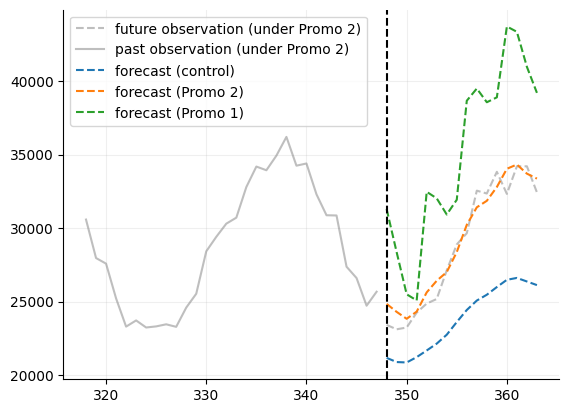

In [78]:
# plot 

fig, ax = plt.subplots()

target_future_df = df_all.loc[(df_all.index > test_time_stamp) & (df_all.product_id == target_unit)]
target_df = df_all.loc[(df_all.index <= test_time_stamp) & (df_all.product_id == target_unit)]
promo = target_future_df.loc[:,"promo"].values[0]
promo_past = target_df.loc[:,"promo"].values[-1]

ax.plot(np.arange(T, T+test_t), target_future_df["sales"], '--',color = "tab:gray", label = f"future observation (under {promo})", alpha = 0.5)
ax.plot(np.arange(T-30, T), target_df["sales"].values[-30:],  color = "tab:gray",  label = f"past observation (under {promo_past})", alpha = 0.5)
ax.plot(forecast_ctrl.T, '--',label = "forecast (control)")
ax.plot(forecast_coupons.T, '--', label = "forecast (Promo 2)")
ax.plot(forecast_email.T, '--',label = "forecast (Promo 1)")
ax.axvline(T, linestyle = "dashed", color = "black")

ax.grid(True, which='both', linestyle='-', alpha=0.2)

# Remove upper and left boundaries
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.legend()
plt.show()

Answering all these indvidual-level questions naturally enables us to answer question about the effectiveness of each intervention compared to control (on average across time and products).

### 4. Can we estimate the average treatment effect (ATE) for each intervention despite access to observatoinal data only?

To do so, we first query the counterfactual for all units.

In [79]:
all_units_under_control = model.query(
            # units have ID's 0 to 99
            units= np.arange(100), 
            time = ["2016-12-25", test_time_stamp],
            metric= 'sales', action= 'control', 
            action_time_range=["2016-12-25", test_time_stamp])

all_units_under_promo1 = model.query(units= np.arange(100), 
            time = ["2016-12-25", test_time_stamp],
            metric= 'sales', action= 'Promo 1', 
            action_time_range=["2016-12-25", test_time_stamp])

all_units_under_promo2 = model.query(units= np.arange(100), 
            time = ["2016-12-25", test_time_stamp],
            metric= 'sales', action= 'Promo 2', 
            action_time_range=["2016-12-25", test_time_stamp])

ATE_estimate = {"Promo 1" : [np.mean((all_units_under_promo1 - all_units_under_control).values)],
      "Promo 2" : [np.mean((all_units_under_promo2 - all_units_under_control).values)]}

<Axes: title={'center': 'estimated ATE'}>

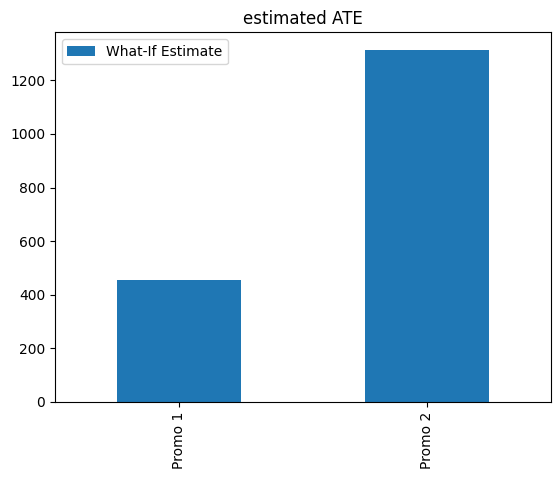

In [80]:
ATE_estimate_df = pd.DataFrame.from_dict(ATE_estimate)
ATE_estimate_df.index = ["What-If Estimate"]
ATE_estimate_df.T.plot.bar(title = "estimated ATE")


## Evaluation

Luckily, since the data is a synthetic one, we can evaluate the accuracy of our answers above. 

Let's start with the counterfactual questions. 

### How good are counterfactual estimates?

In [81]:
# Load true data in the form of a tensor (no. products, time, no. interventions) 

tensor = np.load("data/product_sales/tensor.npy")[...,0]

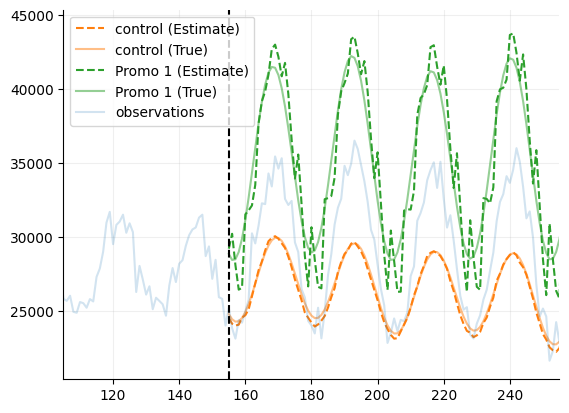

In [82]:
df_query = model.query(units= [target_unit], 
            time = ["2016-12-20", test_time_stamp],
            metric= 'sales', action= 'control', 
            action_time_range=["2016-12-15", " 2020-12-19"])

fig, ax = plt.subplots()
ax.plot(np.arange(T0, T),df_query.T.values,'--', color = "tab:orange",  label  = "control (Estimate)")
ax.plot(np.arange(T0, T),tensor[target_unit,T0:T,0],'-', color = "tab:orange",  label  = "control (True)", alpha = 0.5)

df_query = model.query(units= [target_unit], 
            time = ["2016-12-20", test_time_stamp],
            metric= 'sales', action= 'Promo 1', 
            action_time_range=["2016-12-15", " 2020-12-19"])


ax.plot(np.arange(T0, T), df_query.T.values, '--', color = "tab:green", label  = "Promo 1 (Estimate)")
ax.plot(np.arange(T0, T),tensor[target_unit,T0:T,1],'-', color = "tab:green",  label  = "Promo 1 (True)", alpha = 0.5)

ax.plot(df.loc[(df.product_id == target_unit) ,  ['sales']].values, alpha = 0.2, label = "observations")
ax.axvline(T0, linestyle = "dashed", color = "black")
ax.set_xlim(T0-50,T0+100)

ax.grid(True, which='both', linestyle='-', alpha=0.2)

# Remove upper and left boundaries
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.legend()
plt.show()

Visually, the estimates look very accurate indeed! Further, we can test whether the estimate for **all unit** is great in terms of the Mean Average Percentage Error (MAPE).

In [83]:
def mape(y_true, y_est):
    return 100*np.abs(y_true - y_est).mean()/y_true.mean()


control_mape = mape(all_units_under_control.values , tensor[:, T0:T, 0])
email_mape = mape(all_units_under_promo1.values , tensor[:, T0:T, 1])
coupons_mape = mape(all_units_under_promo2.values , tensor[:, T0:T, 2])
print(f"MAPE under control: {control_mape:.3f}")
print(f"MAPE under Promo 1: {email_mape:.3f}")
print(f"MAPE under coupons: {coupons_mape:.3f}")

MAPE under control: 1.078
MAPE under Promo 1: 6.221
MAPE under coupons: 2.969


### How good are froecasts?

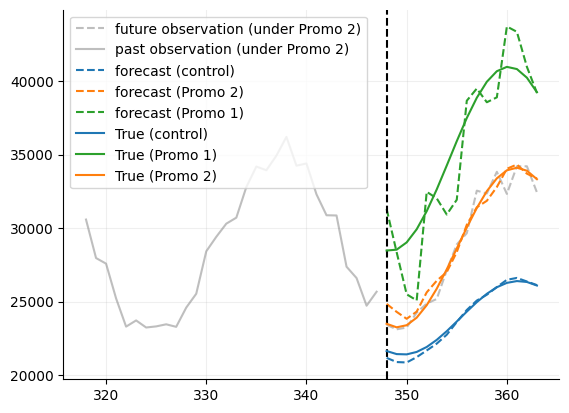

In [84]:
# plot 

fig, ax = plt.subplots()

target_future_df = df_all.loc[(df_all.index > test_time_stamp) & (df_all.product_id == target_unit)]
target_df = df_all.loc[(df_all.index <= test_time_stamp) & (df_all.product_id == target_unit)]
promo = target_future_df.loc[:,"promo"].values[0]
promo_past = target_df.loc[:,"promo"].values[-1]

ax.plot(np.arange(T, T+test_t), target_future_df["sales"], '--',color = "tab:gray", label = f"future observation (under {promo})", alpha = 0.5)
ax.plot(np.arange(T-30, T), target_df["sales"].values[-30:],  color = "tab:gray",  label = f"past observation (under {promo_past})", alpha = 0.5)
ax.plot(forecast_ctrl.T, '--',label = "forecast (control)")
ax.plot(forecast_coupons.T, '--', label = "forecast (Promo 2)")
ax.plot(forecast_email.T, '--',label = "forecast (Promo 1)")
ax.axvline(T, linestyle = "dashed", color = "black")

plt.plot(np.arange(T, T+test_t), tensor[target_unit,-test_t:,0], color = "tab:blue", label = "True (control)")
plt.plot(np.arange(T, T+test_t), tensor[target_unit,-test_t:,1], color = "tab:green", label = "True (Promo 1)")
plt.plot(np.arange(T, T+test_t), tensor[target_unit,-test_t:,2], color = "tab:orange", label = "True (Promo 2)")

ax.grid(True, which='both', linestyle='-', alpha=0.2)

# Remove upper and left boundaries
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.legend()
plt.show()

Again visually, the forecasts look very accurate for the target unit! Further, we can test whether the forecasts for **all unit** is great in terms of the Mean Average Percentage Error (MAPE).

In [85]:
# forecast all units
# forecast under control for test_t timesteps 
forecast_ctrl = model.forecast(
            units= np.arange(100), 
            steps_ahead = test_t,
            metric= 'sales', action= 'control', 
            )

# forecast under Promo 1 for test_t timesteps 
forecast_email = model.forecast(
            units= np.arange(100), 
            steps_ahead = test_t,
            metric= 'sales', action= 'Promo 1', 
            )

# forecast under Promo 2 for test_t timesteps 
forecast_coupons = model.forecast(
            units= np.arange(100), 
            steps_ahead = test_t,
            metric= 'sales', action= 'Promo 2', 
            )


control_mape_f = mape(forecast_ctrl.values , tensor[:,-test_t:,0])
email_mape_f = mape(forecast_email.values , tensor[:,-test_t:,1])
coupons_mape_f = mape(forecast_coupons.values , tensor[:,-test_t:,2])
print(f"MAPE under control: {control_mape_f:.3f}")
print(f"MAPE under Promo 1: {email_mape_f:.3f}")
print(f"MAPE under coupons: {coupons_mape_f:.3f}")

MAPE under control: 1.431
MAPE under Promo 1: 7.686
MAPE under coupons: 3.566


## How good is the ATE estimate? vs baselines?

Let's first estimate the True ATE

In [86]:
ATE_true = {"Promo 1" : np.mean(tensor[:,T0:T,1] - tensor[:,T0:T,0] ), "Promo 2" : np.mean(tensor[:,T0:T,2] - tensor[:,T0:T,0] )}

#### Estimate ATE using baselines 

In [87]:
df.columns

Index(['product_id', 'time', 'category', 'gender', 'is_discounted',
       'is_limited_edition', 'is_fair_trade', 'is_returnable',
       'has_size_option', 'is_machine_washable', 'is_premium', 'is_ironable',
       'is_imported', 'white_label', 'sales', 'promo',
       'intervention_assignment'],
      dtype='object')

In [88]:
confounders = ['category', 'gender']#, 'is_discounted',
       # 'is_limited_edition', 'is_fair_trade', 'is_returnable',
       # 'has_size_option', 'is_machine_washable', 'is_premium', 'is_ironable',
       # 'is_imported', 'white_label']
ATE_ipw = ipw_estimator(
      df, treatment = "promo", 
      confounders = confounders, 
      outcome = "sales", 
    int_labels = ["control", "Promo 1", "Promo 2"]
    )

ATE_ipw_forest = ipw_estimator(
      df, treatment = "promo", 
      confounders = confounders,
      outcome = "sales", 
    int_labels = ["control", "Promo 1", "Promo 2"],
    method = RandomForestClassifier,
    kwargs = {}
    )

ATE_naive = naive_ATE(df, treatment = "promo", outcome = "sales",int_labels = ["control", "Promo 1", "Promo 2"])




In [89]:

res_df = pd.DataFrame(
                  columns = ["ATE(1)", "ATE(2)"], index = ["IPW-logistic-regression", "IPW-random-forest", "Naive",  "WhatIf", "True"])
res_df.loc["IPW-logistic-regression"] = ATE_ipw[0][1:]
res_df.loc["IPW-random-forest"] = ATE_ipw_forest[0][1:]
res_df.loc["Naive"] = ATE_naive[0][1:]
res_df.loc["WhatIf"] = [ATE_estimate["Promo 1"][0], ATE_estimate["Promo 2"][0]]
res_df.loc["True"] = [ATE_true["Promo 1"], ATE_true["Promo 2"]]
res_df

,ATE(1),ATE(2)
IPW-logistic-regression,2609.637888,2208.812176
IPW-random-forest,2101.149535,2183.686393
Naive,2216.823873,2495.504124
WhatIf,456.338053,1313.556481
True,637.703163,1254.939446


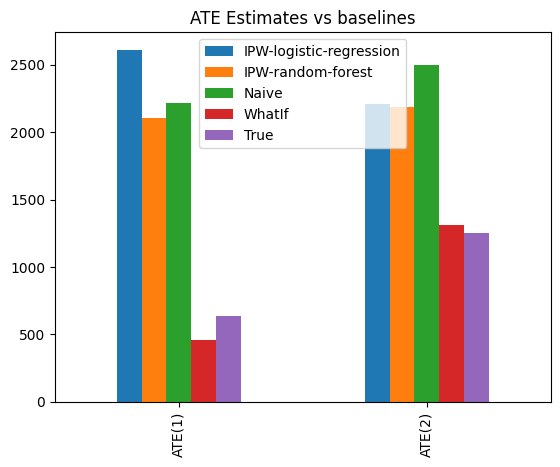

In [90]:
res_df.T.plot.bar(title = "ATE Estimates vs baselines")
plt.show()


## Final note about scalability


We use the what-if algorithm called `SNN` in this notebook. This algorithm is not very scalable (scalablity varies with different sparsity patterns). If the `fit` function take too much time for your data, use `SNNBiclustering` which is faster but approximate the SNN estimates. 